# Implement Attention from Scratch
###  Problem Statement
Transformers are order-agnostic — they see tokens like goldfish: no sense of sequence. To inject **position awareness** into the model, we use **Sinusoidal Positional Embeddings**, where each position in the sequence gets a unique deterministic vector. These vectors are computed using sine and cosine waves at different frequencies.

Your task is to implement the sinusoidal position encoding mechanism from scratch using PyTorch — no cheating with built-ins from `fairseq` or Hugging Face.

---

###  Requirements

1. **Define the Sinusoidal Embedding Class**
   - Implement a `SinusoidalPositionalEmbedding` class inheriting from `nn.Module`.
   - Initialize with `max_seq_len` and `d_model`.
   - Create a tensor `pe` of shape `(max_seq_len, d_model)` filled with sine and cosine encodings:
     - `sin(position * ω)` for even indices
     - `cos(position * ω)` for odd indices

2. **Register as Buffer**
   - Use `self.register_buffer("pe", pe)` to store `pe` without treating it as a trainable parameter.

3. **Generate Encodings**
   - On calling `forward(x)`, return the slice of positional encodings matching the sequence length of `x`.

4. **Test the Embeddings**
   - Initialize the embedding class with `max_seq_len = 100` and `d_model = 64`.
   - Pass a sequence of length 50 to verify the returned shape is `(1, 50, 64)`.

---

### Constraints

- ✅ Do not use Hugging Face, Fairseq, or built-in PyTorch modules for position encoding.
- ✅ Ensure the `pe` tensor is not a trainable parameter.
- ✅ Support any sequence length up to `max_seq_len`.
- ❌ Do not inject these embeddings directly into token embeddings yet — this is just the embedding module.

---

<details>
  <summary>💡 Hint</summary>

  - Use `torch.arange(0, max_seq_len).unsqueeze(1)` to create position indices.
  - Compute frequencies with `torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))`.
  - Alternate `sin` and `cos` values for even and odd embedding dimensions.
  - When returning the embedding in `forward`, use `.unsqueeze(0)` to broadcast over the batch dimension.

</details>

In [84]:
(1-np.arange(10)%2)

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [ ]:
import torch
import numpy as np
class SinusoidalPositionalEmbeddingsInitialImeplementation(torch.nn.Module):
    def __init__(self, n_dim):
        super().__init__()
        self.n_dim = n_dim

    def get_sine_wave(self, idx):
        return np.sin(idx/(10000**(np.arange(self.n_dim)/self.n_dim)))

    def get_cos_wave(self, idx):
        return np.cos(idx/(10000**(np.arange(self.n_dim)/self.n_dim)))

    def forward(self, idx):
        if isinstance(idx, int):
            print(idx)
            if idx%2 == 0:
                return self.get_sine_wave(idx)
            elif idx%2 == 1:
                return self.get_cos_wave(idx)
        else:
            sine_op = self.get_sine_wave(idx)*(1-np.arange(self.n_dim)%2)
            cos_op = self.get_cos_wave(idx)*(np.arange(self.n_dim)%2)
            return sine_op+cos_op

class SinusoidalPositionalEmbeddingsFixed(torch.nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float)
            * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer("pe", pe)

    def forward(self, seq_len):
        # returns (seq_len, d_model)
        return self.pe[:seq_len]


n_dim = 16
spe = SinusoidalPositionalEmbeddings(n_dim)
spe_fixed = SinusoidalPositionalEmbeddingsFixed(n_dim)
embeddings_fixed = spe_fixed(1000).T
embeddings = spe(np.arange(1000).reshape(-1,1)).T
# spe.get_sine_wave(np.arange(64).reshape(-1,1))

In [44]:
class SinusoidalPositionalEmbeddings(torch.nn.Module):
    def __init__(self, n_dim):
        super().__init__()
        self.n_dim = n_dim

    def get_sine_wave(self, idx):
        return np.sin(idx/(10000**(np.arange(0,self.n_dim,2).reshape(1,-1)/self.n_dim)))

    def get_cos_wave(self, idx):
        return np.cos(idx/(10000**(np.arange(0,self.n_dim,2).reshape(1,-1)/self.n_dim)))

    # INITIAL FAULTY IMPLEMENTATION
    # def forward(self, idx):
    #     if isinstance(idx, int):
    #         print(idx)
    #         if idx%2 == 0:
    #             return self.get_sine_wave(idx)
    #         elif idx%2 == 1:
    #             return self.get_cos_wave(idx)
    #     else:
    #         sine_op = self.get_sine_wave(idx)*(1-np.arange(self.n_dim)%2)
    #         cos_op = self.get_cos_wave(idx)*(np.arange(self.n_dim)%2)
    #         return sine_op+cos_op

    def forward(self, seq_len):
        output = np.zeros(shape=(seq_len, self.n_dim))
        idx = np.arange(start=0, stop=seq_len, step=1).reshape(-1,1)
        output[:,::2] = self.get_sine_wave(idx)
        output[:,1::2] = self.get_cos_wave(idx)
        return output[:seq_len, :]


n_dim = 256
spe = SinusoidalPositionalEmbeddings(n_dim)
embeddings = spe(100).round(4).T

In [39]:
embeddings

array([[ 0.    ,  0.8415,  0.9093, ...,  0.3796, -0.5734, -0.9992],
       [ 1.    ,  0.5403, -0.4161, ..., -0.9251, -0.8193,  0.0398],
       [ 0.    ,  0.802 ,  0.9581, ...,  0.7451, -0.0898, -0.8523],
       ...,
       [ 1.    ,  0.9995,  0.998 , ..., -0.9972, -0.9991, -0.9999],
       [ 0.    ,  0.0294,  0.0588, ...,  0.2832,  0.2549,  0.2263],
       [ 1.    ,  0.9996,  0.9983, ..., -0.9591, -0.967 , -0.9741]])

In [20]:
start_pos_1 = 6
start_pos_2 = 12
delta = 10
end_pos_1 = start_pos_1 + delta
end_pos_2 = start_pos_2 + delta
embeddings[:,start_pos_1] @ embeddings[:,end_pos_1], embeddings[:,start_pos_2] @ embeddings[:,end_pos_2]

(-1.7378176549393753, 2.176996135598102)

In [21]:
((embeddings_fixed[:,start_pos_1] @ embeddings_fixed[:,end_pos_1]) == (embeddings_fixed[:,start_pos_2] @ embeddings_fixed[:,end_pos_2])).item()

NameError: name 'embeddings_fixed' is not defined

In [165]:
(((embeddings_fixed[::2,:]**2 + embeddings_fixed[1::2,:]**2) - torch.tensor(1.000)).abs() > torch.tensor(1e-6)).sum().item()

0

In [150]:
start_idx = 3
end_idx = 2
embeddings_fixed[:,:4].T[:,start_idx], embeddings_fixed[:,:4].T[:,end_idx], embeddings_fixed[:,:4].T[:,start_idx]**2 + embeddings_fixed[:,:4].T[:,end_idx]**2

(tensor([1.0000, 0.9504, 0.8066, 0.5828]),
 tensor([0.0000, 0.3110, 0.5911, 0.8126]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000]))

In [43]:
start_idx = 12
end_idx = 13
embeddings[:,:4].T[:,start_idx], embeddings[:,:4].T[:,end_idx], embeddings[:,:4].T[:,start_idx]**2 + embeddings[:,:4].T[:,end_idx]**2

(array([0.    , 0.6047, 0.9632, 0.9296]),
 array([ 1.    ,  0.7965,  0.2687, -0.3685]),
 array([1.        , 1.00007434, 0.99995393, 0.99994841]))

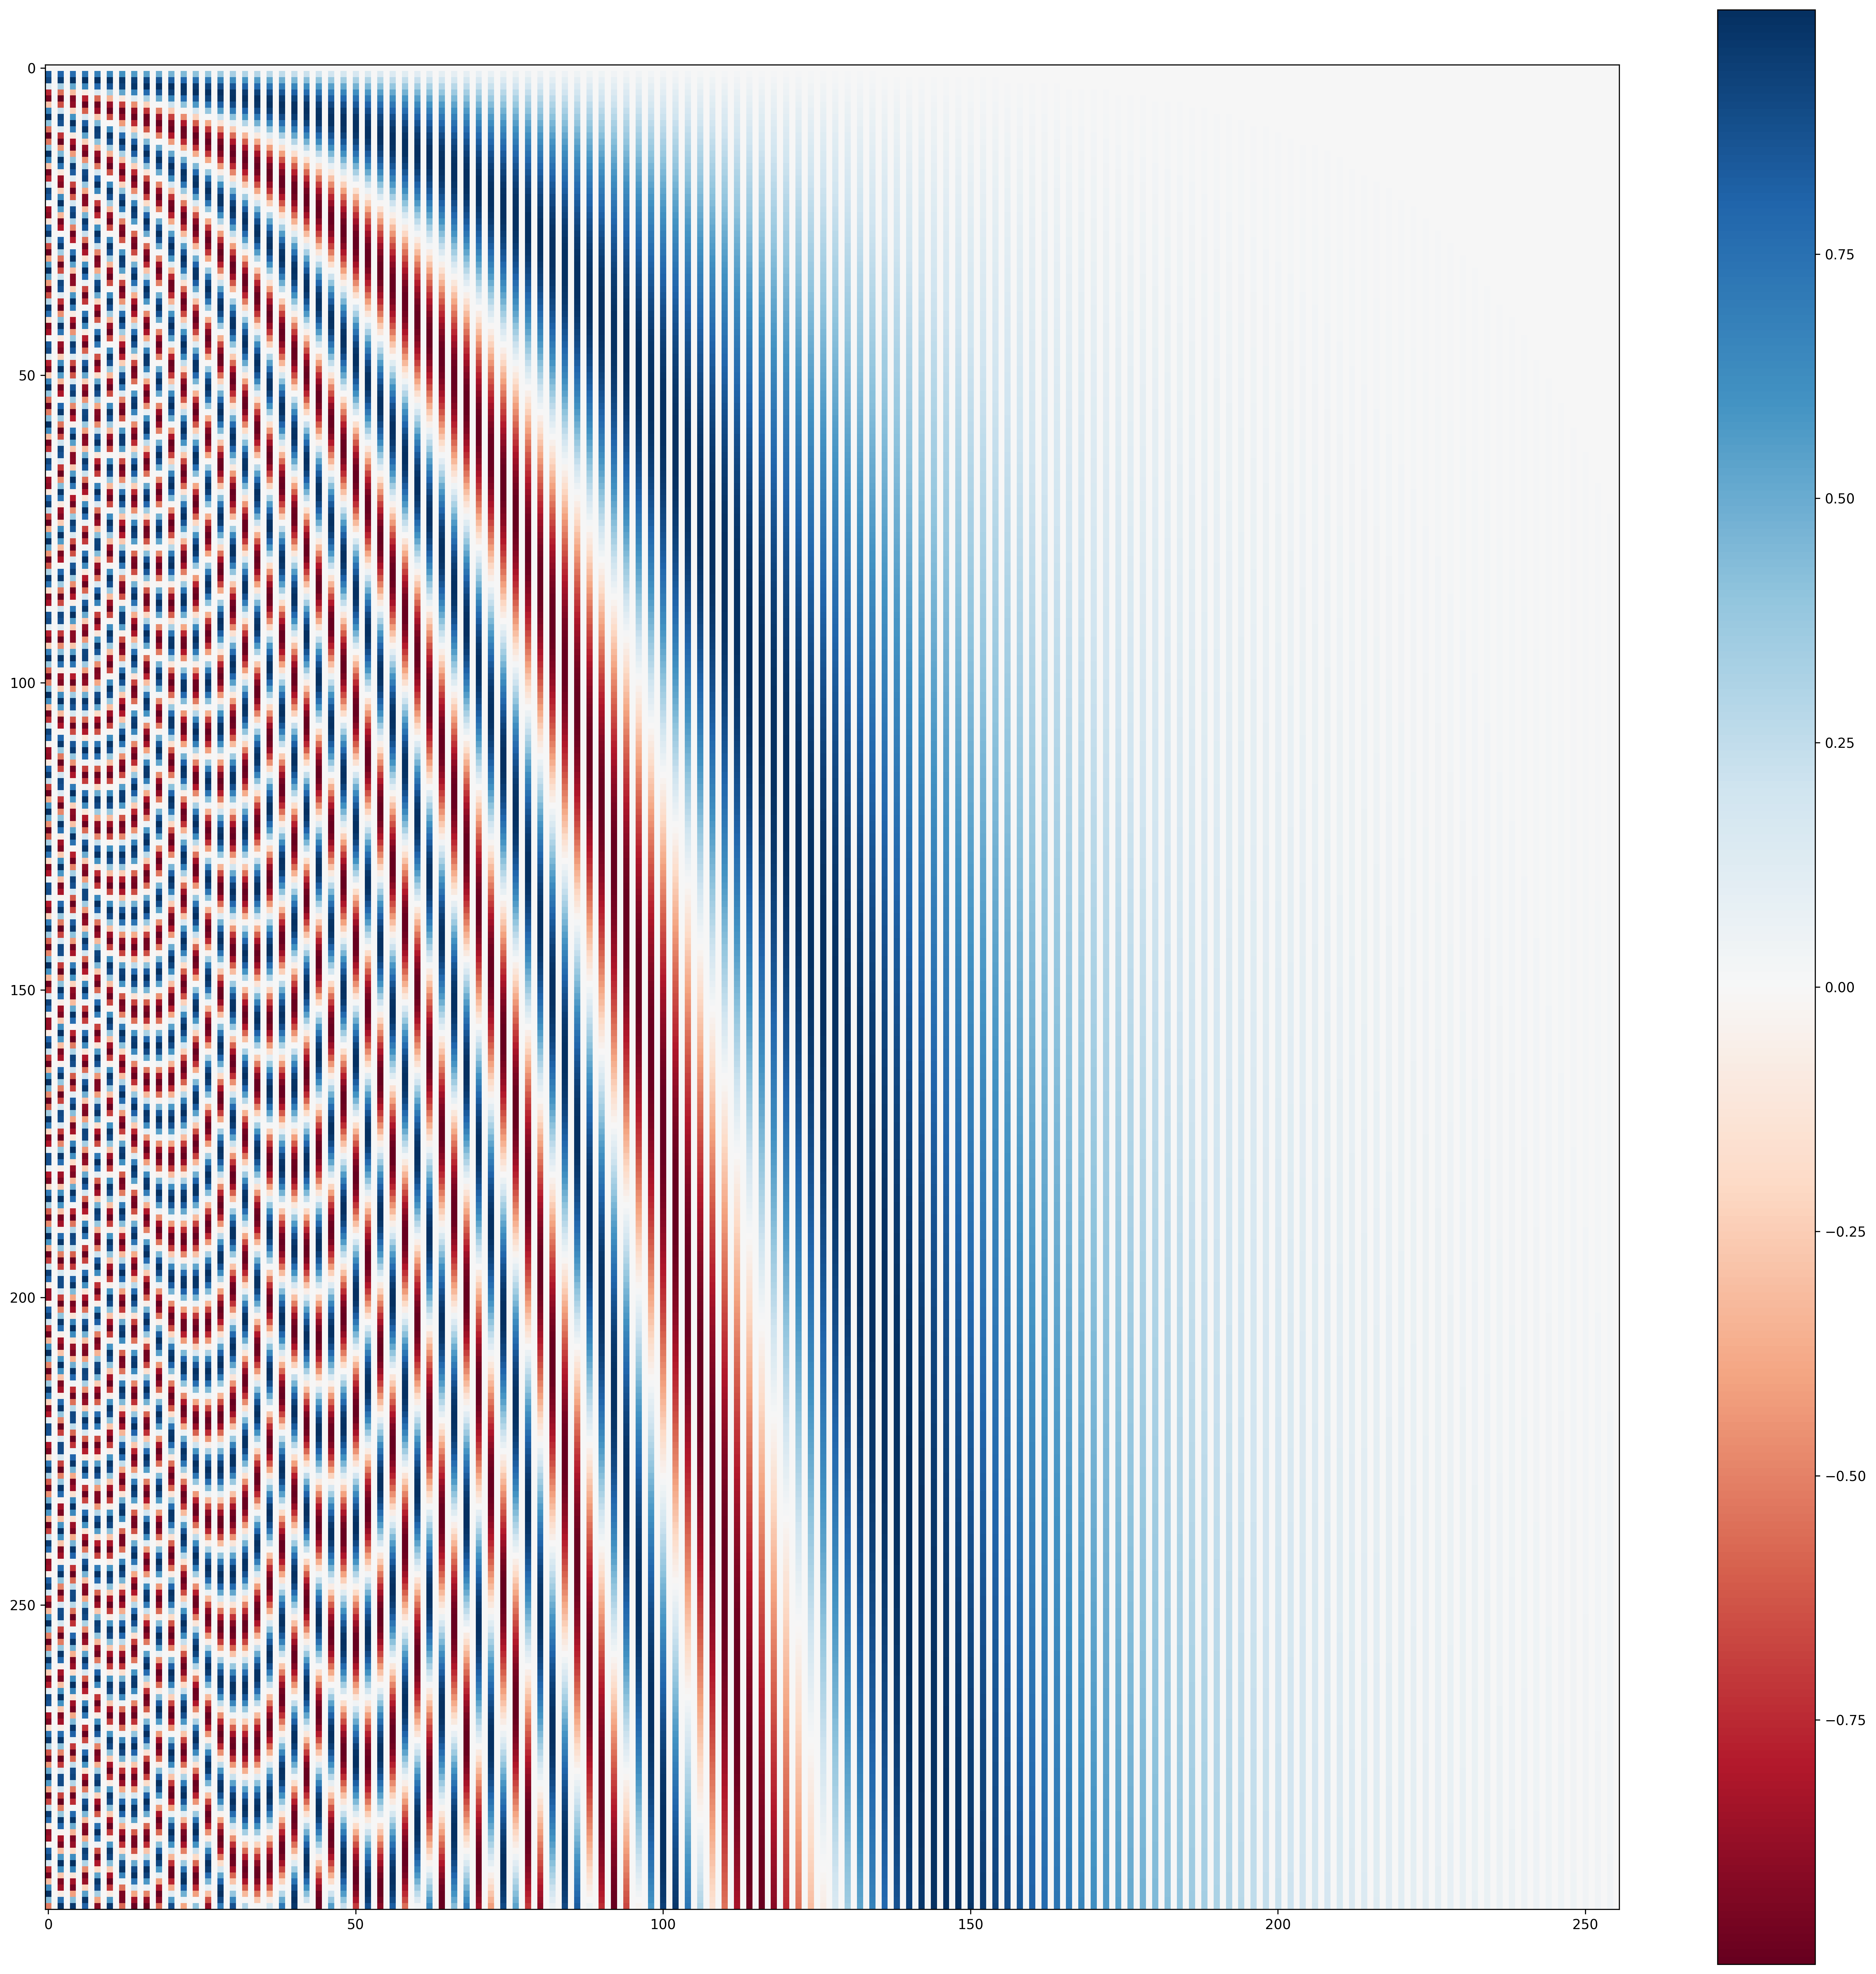

In [126]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(26,26))
img = plt.imshow((spe.get_sine_wave(np.arange(300).reshape(-1,1)))*(1-np.arange(256)%2), cmap='RdBu')
plt.colorbar(img)
plt.show()

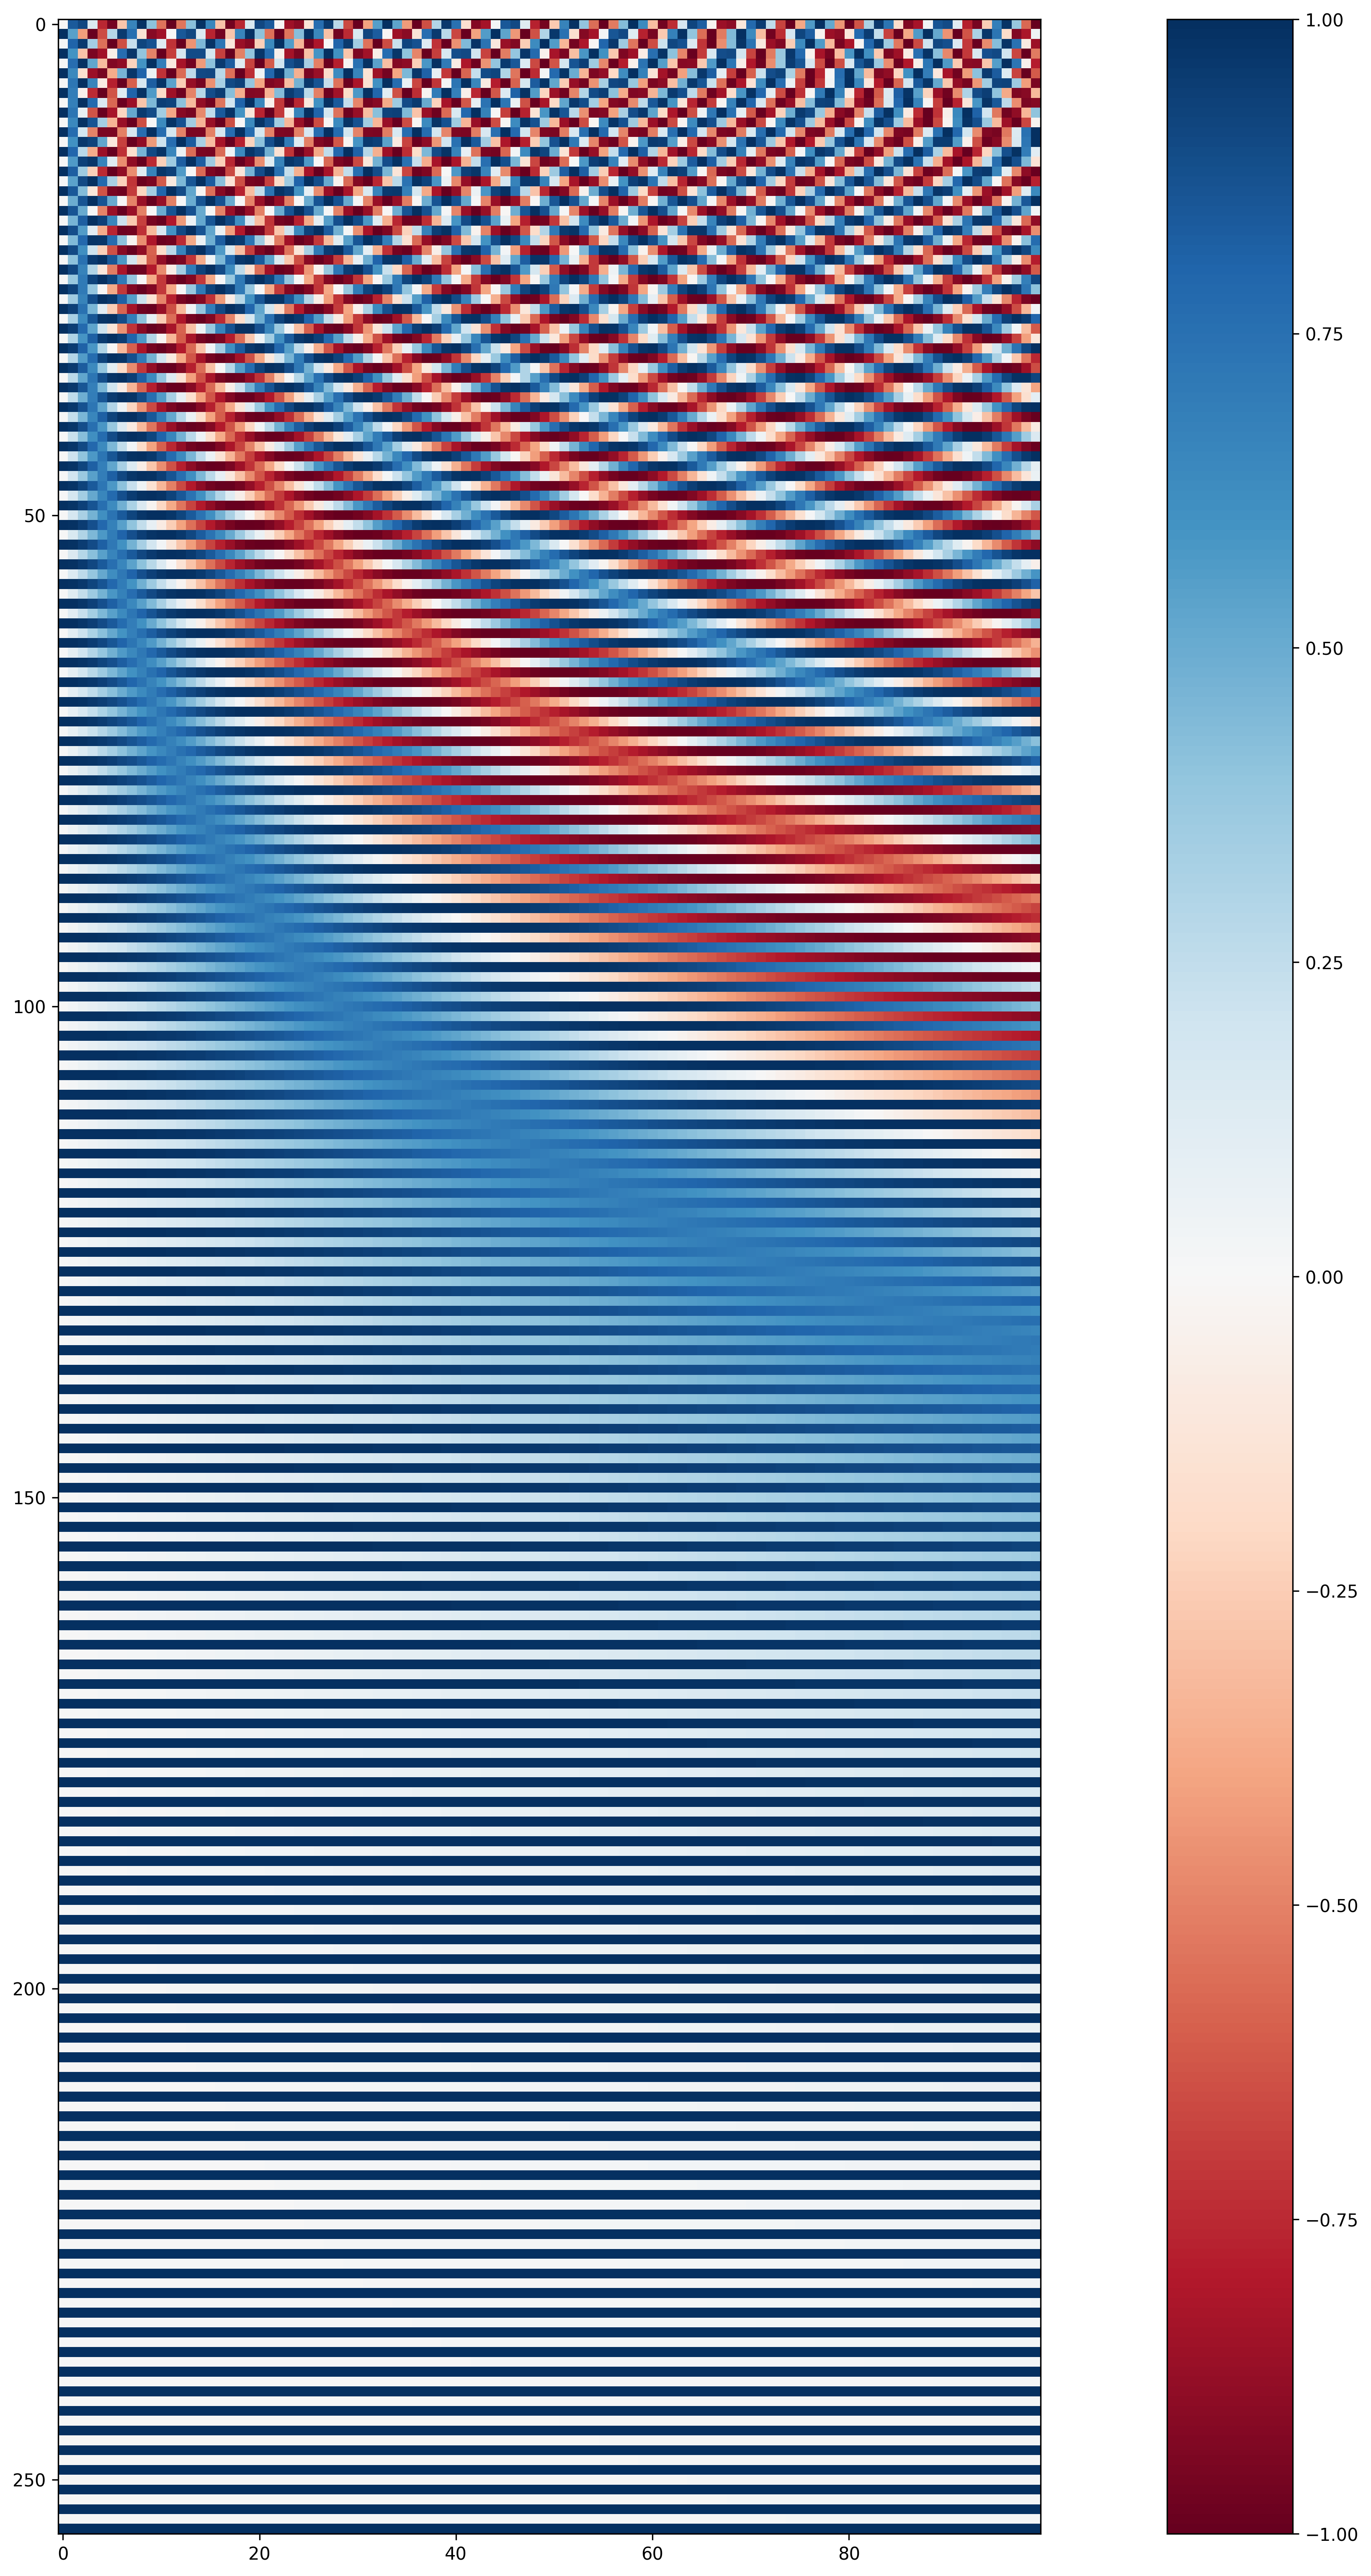

In [47]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(26,26))
img = plt.imshow(embeddings, cmap='RdBu')
plt.colorbar(img)
plt.show()

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

In [ ]:
# Synthetic data
torch.manual_seed(42)
batch_size = 3
seq_len = 4
d_model = 8
num_heads = 2

q = torch.rand(batch_size, seq_len, d_model)
k = torch.rand(batch_size, seq_len, d_model)
v = torch.rand(batch_size, seq_len, d_model)
print(q.shape)

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [ ]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len: int, d_model: int):
        """
        Initializes the sinusoidal positional embedding.
        
        Args:
            max_seq_len (int): Maximum sequence length.
            d_model (int): Embedding dimension.
        """
        ...

    def forward(self, x):
        """
        Returns the positional embedding for a given input tensor.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, d_model).
        
        Returns:
            Tensor: Positional embeddings of shape (batch_size, seq_len, d_model).
        """
        ...

In [ ]:
# from fairseq.modules.sinusoidal_positional_embedding import SinusoidalPositionalEmbedding

max_seq_len = 100
d_model = 64

# Fairseq's implementation requires the number of embeddings (seq length) and embedding dim
# pos_emb = SinusoidalPositionalEmbedding(d_model, max_seq_len, padding_idx=None)

# Generate embeddings for a sequence of length 50
seq_len = 50
positions = torch.arange(seq_len).unsqueeze(0)  # Shape: (1, seq_len)
# positional_encoding = pos_emb(positions)  # Shape: (1, seq_len, d_model)

custom_pos_emb = SinusoidalPositionalEmbedding(d_model, max_seq_len)

positional_encoding_custom = custom_pos_emb(positions)

print(positional_encoding_custom.shape)  # (1, 50, 64)


In [4]:
import numpy as np
x = np.zeros(shape=(8,8))
x

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
x[:,::3] = 1
x[:,1::3] = 2
x[:,2::3] = 3

x

array([[1., 2., 3., 1., 2., 3., 1., 2.],
       [1., 2., 3., 1., 2., 3., 1., 2.],
       [1., 2., 3., 1., 2., 3., 1., 2.],
       [1., 2., 3., 1., 2., 3., 1., 2.],
       [1., 2., 3., 1., 2., 3., 1., 2.],
       [1., 2., 3., 1., 2., 3., 1., 2.],
       [1., 2., 3., 1., 2., 3., 1., 2.],
       [1., 2., 3., 1., 2., 3., 1., 2.]])

In [12]:
np.arange(start=0, stop=11, step=2)

array([ 0,  2,  4,  6,  8, 10])